# Unconditional image generation

Unconditional image generation is a relatively straightforward task. The model only generates images - without any additional context like text or an image - resembling the training data it was trained on.

The [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) is the easiest way to use a pre-trained diffusion system for inference.

Start by creating an instance of [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) and specify which pipeline checkpoint you would like to download.
You can use any of the Diffusers [checkpoints](https://huggingface.co/models?library=diffusers&sort=downloads) from the Hub (the checkpoint you'll use generates images of butterflies).

TIP:

In this notebook, you'll use [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) for unconditional image generation with [DDPM](https://arxiv.org/abs/2006.11239) (Denoising Diffusion Probabilistic Models):

In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00


In [2]:
!pip3 install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 12.0 MB/s eta 0:00:00


In [3]:
import transformers

In [4]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00


In [5]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
from pprint import pprint
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
from transformers import TFAutoModelForMaskedLM, AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer, top_k_top_p_filtering
from torch import nn
from accelerate import Accelerator
from diffusers import DiffusionPipeline

In [6]:
generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128")

unet/diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

The [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) downloads and caches all modeling, tokenization, and scheduling components.
Because the model consists of roughly 1.4 billion parameters, we strongly recommend running it on a GPU.
You can move the generator object to a GPU, just like you would in PyTorch:

In [7]:
generator.to("cuda")

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.17.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

Now you can use the `generator` to generate an image:

In [8]:
image = generator().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

The output is by default wrapped into a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=image#the-image-class) object.

You can save the image by calling:

In [11]:
image.save("generated_image.png")

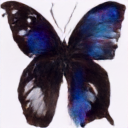

In [12]:
image

In [13]:
image1 = generator().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

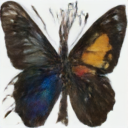

In [14]:
image1

Try out the Spaces below, and feel free to play around with the inference steps parameter to see how it affects the image quality!

<iframe
	src="https://stevhliu-ddpm-butterflies-128.hf.space"
	frameborder="0"
	width="850"
	height="500"
></iframe>

https://huggingface.co/docs/diffusers/using-diffusers/unconditional_image_generation




---



---



---



---



A common way to improve the quality of generated images is with deterministic batch generation, generate a batch of images and select one image to improve with a more detailed prompt in a second round of inference. The key is to pass a list of torch.Generator’s to the pipeline for batched image generation, and tie each Generator to a seed so you can reuse it for an imag

In [15]:
prompt = "Labrador in the style of Vermeer"


In [16]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Now, define four different Generator’s and assign each Generator a seed (0 to 3) so you can reuse a Generator later for a specific image:

In [23]:
generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]

In [24]:
images = pipe(prompt, generator=generator, num_images_per_prompt=4).images
images

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_dif │
│ fusion.py:705 in __call__                                                                        │
│                                                                                                  │
│   702 │   │                                                                                      │
│   703 │   │   # 5. Prepare latent variables                                                      │
│   704 │   │   num_channels_latents = self.unet.config.in_channels                                │
│ ❱ 705 │   │   latents = self.prepare_latents(                                                    │
│   706 │   │   │   batch_size * num_images_per_prompt,                                            │
│   707 │   │   │   num_channels_latents,                                                          │
│   708 │   │   │   height,                                                                        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_dif │
│ fusion.py:550 in prepare_latents                                                                 │
│                                                                                                  │
│   547 │   def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, de   │
│   548 │   │   shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, widt   │
│   549 │   │   if isinstance(generator, list) and len(generator) != batch_size:                   │
│ ❱ 550 │   │   │   raise ValueError(                                                              │
│   551 │   │   │   │   f"You have passed a list of generators of length {len(generator)}, but r   │
│   552 │   │   │   │   f" size of {batch_size}. Make sure the batch size matches the length of    │
│   553 │   │   │   )                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: You have passed a list of generators of length 4, but requested an effective batch size of 16. Make 
sure the batch size matches the length of the generators.

In this example, you’ll improve upon the first image - but in reality, you can use any image you want (even the image with double sets of eyes!). The first image used the Generator with seed 0, so you’ll reuse that Generator for the second round of inference. To improve the quality of the image, add some additional text to the prompt:

In [19]:
prompt = [prompt + t for t in [", highly realistic", ", artsy", ", trending", ", colorful"]]
generator = [torch.Generator(device="cuda").manual_seed(0) for i in range(4)]

In [25]:
images = pipe(prompt, generator=generator).images
images

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FAD33579BD0>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7FAD3357A6B0>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7FAD3357BA30>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7FAD33579720>]